# 프로젝트 - Movielens 영화 SBR

[Movielens 1M Dataset](https://grouplens.org/datasets/movielens/1m/)을 기반으로, Session based Recommendation 시스템을 제작해보자.

#### ✔︎ 모듈 불러오기

In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
import datetime as dt
from pathlib import Path
import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings('ignore')

#### ✔︎ 데이터 불러오기

In [2]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose/data/') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


- 이 데이터셋은 명확한 1회 세션의 SessionID를 포함하지 않고 있기 때문에 SessionID에 대한 정확한 정의가 필요하다.
- Rating 정보가 포함되어 있기에 잘 활용할 수 있는 방안을 찾아야 한다.
- Time 항목에는 UTC time이 포함되어, 1970년 1월 1일부터 경과된 초 단위 시간이 기재되어 있다.

---
## Step 1. 데이터의 전처리

### 1) 항목별 기본 분석


In [3]:
data['UserId'].nunique() 

6040

In [4]:
data['ItemId'].nunique()

3706

In [5]:
data['Rating'].unique()

array([4, 5, 3, 2, 1], dtype=int32)

In [6]:
data['Time'].nunique()

458455

전체 데이터의 열(row) 개수가 1000209개인데, Time이 458455개인 것으로 봐서 Timestamp가 중복된 경우가 많다는 것을 알 수 있다. 여러 명의 유저가 동시에 클릭하는 경우도 있겠지만, 대부분 하나의 유저가 여러 아이템에 대해 동시에 클릭하는 경우가 더 많을 것이다.<br><br> 보통 한 세션이라 함은, 한 유저가 특정한 시간에 어떤 대상을 클릭하는 하나의 사건을 지정해주는 경우가 많다. 그러나 이 데이터에서 단순하게 UserId가 SessionId를 대체한다고 가정한다면, 동일한 시간에 하나의 아이디에 대한 여러 개의 세션이 생겨나게 되어 이상한 오류가 발생할 수 있다.
<br> 때문에 여기서는 하나의 유저가 동시에 여러 개의 영화에 대한 평가를 내린 경우를 한 세션으로 정의하여 오류가 생길 가능성을 줄여보고자 한다.

### 2) Session ID 항목 만들기
UserId와 Time이 같은 경우를 하나의 세션으로 가정하여 SessionId라는 새로운 항목을 만들어주려고 한다.

In [7]:
data['Session'] = data.apply(lambda x: str(x['UserId']) + '=' + str(x['Time']), axis=1)
data = data.reset_index(drop=True)
data

,UserId,ItemId,Rating,Time,Session
0,1,3186,4,978300019,1=978300019
1,1,1270,5,978300055,1=978300055
2,1,1721,4,978300055,1=978300055
3,1,1022,5,978300055,1=978300055
4,1,2340,3,978300103,1=978300103
...,...,...,...,...,...
1000204,6040,2917,4,997454429,6040=997454429
1000205,6040,1921,4,997454464,6040=997454464
1000206,6040,1784,3,997454464,6040=997454464
1000207,6040,161,3,997454486,6040=997454486


In [8]:
data_sid = data['Session'].drop_duplicates().reset_index(drop=True)
data_sid = data_sid.reset_index()
data_sid

,index,Session
0,0,1=978300019
1,1,1=978300055
2,2,1=978300103
3,3,1=978300172
4,4,1=978300275
...,...,...
471158,471158,6040=997454398
471159,471159,6040=997454429
471160,471160,6040=997454464
471161,471161,6040=997454486


In [9]:
data = pd.merge(data, data_sid, how='inner')
data

,UserId,ItemId,Rating,Time,Session,index
0,1,3186,4,978300019,1=978300019,0
1,1,1270,5,978300055,1=978300055,1
2,1,1721,4,978300055,1=978300055,1
3,1,1022,5,978300055,1=978300055,1
4,1,2340,3,978300103,1=978300103,2
...,...,...,...,...,...,...
1000204,6040,2917,4,997454429,6040=997454429,471159
1000205,6040,1921,4,997454464,6040=997454464,471160
1000206,6040,1784,3,997454464,6040=997454464,471160
1000207,6040,161,3,997454486,6040=997454486,471161


In [10]:
data.drop('Session', axis=1, inplace=True)
data.rename(columns={'index':'SessionId'}, inplace=True)
data

,UserId,ItemId,Rating,Time,SessionId
0,1,3186,4,978300019,0
1,1,1270,5,978300055,1
2,1,1721,4,978300055,1
3,1,1022,5,978300055,1
4,1,2340,3,978300103,2
...,...,...,...,...,...
1000204,6040,2917,4,997454429,471159
1000205,6040,1921,4,997454464,471160
1000206,6040,1784,3,997454464,471160
1000207,6040,161,3,997454486,471161


### 3) Session Length 분석

Session Length는 같은 Session ID를 공유하는 데이터 row의 개수를 의미하므로, 각 세션에서 몇 개의 영화를 평가했는지를 나타낼 것이다.

In [11]:
session_length = data.groupby('SessionId').size()
session_length

SessionId
0         1
1         3
2         1
3         1
4         1
         ..
471158    1
471159    1
471160    2
471161    1
471162    1
Length: 471163, dtype: int64

In [12]:
session_length.median(), session_length.mean()

(2.0, 2.1228513274599234)

한 세션 당 평균적으로 약 2개의 영화를 평가하였다.

In [13]:
session_length.min(), session_length.max()

(1, 30)

한 번에 가장 적게 평가한 세션은 1개, 가장 많이 평가한 세션은 30개의 영화를 평가하였다.

In [14]:
session_length.quantile(0.999)

10.0

99.9%의 세션은 길이가 10 이하이다. 길이가 30개인 세션은 이상치로 볼 가능성이 있다. 한 번 살펴보고 판단해보자.

In [15]:
long_session = session_length[session_length==30].index[0]
data[data['SessionId']==long_session]

,UserId,ItemId,Rating,Time,SessionId
112347,731,3044,4,975528402,55117
112348,731,1455,3,975528402,55117
112349,731,1639,5,975528402,55117
112350,731,3244,4,975528402,55117
112351,731,1656,2,975528402,55117
112352,731,3426,4,975528402,55117
112353,731,1829,2,975528402,55117
112354,731,2675,4,975528402,55117
112355,731,802,3,975528402,55117
112356,731,803,5,975528402,55117


세션 길이에 대해 좀더 잘 파악하기 위한 시각화를 할 필요가 있다. 세션 길이 기준 하위 99.9%까지의 분포 누적합은 다음과 같다.

In [16]:
length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

1    0.480048
2    0.713936
3    0.847350
4    0.919684
5    0.958639
6    0.979132
7    0.989772
8    0.994989
9    0.997604
dtype: float64

하위 99.9%까지의 분포 누적합을 시각화해보자.

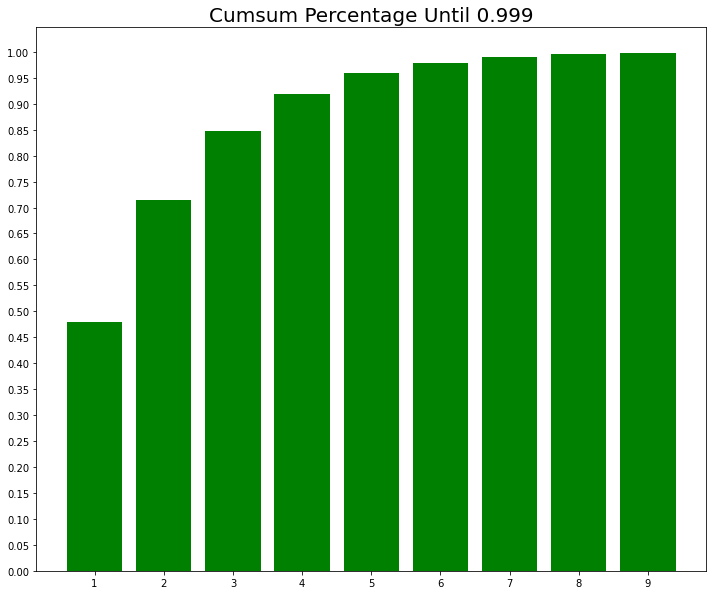

In [17]:
plt.figure(figsize=(12, 10))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='green')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

전체 세션길이 분포 누적합을 시각화해보자.

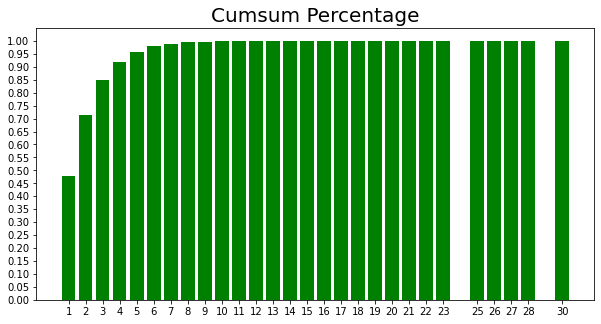

In [18]:
plt.figure(figsize=(10, 5))
plt.bar(x=length_percent_cumsum.index,
        height=length_percent_cumsum, color='green')
plt.xticks(length_percent_cumsum.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage', size=20)
plt.show() 

세션 길이가 10 이상인 데이터들에 대해서는 나중에 모델 학습을 돌려보고와서 결정해 보는것으로 하자.

### 4) Session Time 분석

데이터의 시간 관련 정보를 확인해보자.

In [19]:
oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest) 
print(latest)

956703932
1046454590


Time 항목에는 UTC time이 포함되어, 1970년 1월 1일부터 경과된 초 단위 시간이 기재되어 있다. 이것을 unix time 혹은 epoch time이라고 한다. 이것을 보기 쉽게 현재 날짜와 시간으로 변환시켜야 할 필요가 있다.
<br> [datetime 라이브러리 참조](https://docs.python.org/3/library/datetime.html)

In [20]:
data['Time'] = data['Time'].apply(lambda x: dt.datetime.utcfromtimestamp(x))
data

,UserId,ItemId,Rating,Time,SessionId
0,1,3186,4,2000-12-31 22:00:19,0
1,1,1270,5,2000-12-31 22:00:55,1
2,1,1721,4,2000-12-31 22:00:55,1
3,1,1022,5,2000-12-31 22:00:55,1
4,1,2340,3,2000-12-31 22:01:43,2
...,...,...,...,...,...
1000204,6040,2917,4,2001-08-10 14:40:29,471159
1000205,6040,1921,4,2001-08-10 14:41:04,471160
1000206,6040,1784,3,2001-08-10 14:41:04,471160
1000207,6040,161,3,2001-08-10 14:41:26,471161


In [21]:
oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest) 
print(latest)

2000-04-25 23:05:32
2003-02-28 17:49:50


약 3년치의 데이터가 존재한다. 최근 1년 치의 데이터의 양을 확인해보자.

In [22]:
year_ago = latest - dt.timedelta(365)
print(len(data[data['Time'] > year_ago]))

21704


전체 100만개의 데이터 중에서 최근 1년 치의 데이터가 2만개뿐이다. 2년 치의 데이터 양도 확인해보자.

In [23]:
twoyears_ago = latest - dt.timedelta(365*2)
print(len(data[data['Time'] > twoyears_ago]))

69349


3년 치의 데이터 중 최근 2년 치의 데이터가 약 7만 개 뿐이니, 전체 데이터셋을 다 사용하는 것으로 정한다.

### 5) Rating 분석

In [24]:
data['Rating'].value_counts()

4    348971
3    261197
5    226310
2    107557
1     56174
Name: Rating, dtype: int64

평점이 1, 2인 영화는 선호하지 않는 영화로 간주하고 데이터에서 제외해주도록 하겠다.

In [25]:
data = data[data['Rating'] >= 3]
data['Rating'].value_counts()

4    348971
3    261197
5    226310
Name: Rating, dtype: int64

### 6) 추가적 Data Cleansing에 대해

원래는 추천시스템이기 때문에 세션의 길이가 1인 경우에 대해 다 제거해주는 것이 맞다. 그러나 지금 다루고 있는 데이터셋의 세션 길이는 한 유저가 동시에 평가한 영화의 개수이므로 이것이 과연 추천시스템에서 어떤 영향을 미칠지 판단이 서질 않는다. 애초에 Session based가 아닌 자료에서 세션을 억지로 정의하고 설정했기 때문에 이대로 진행하는 것이 맞는가에 대한 의문이 들긴 하지만, 이 프로젝트에서는 정확한 영화의 추천보다는 모델 훈련과 평가에 더 초점을 맞추었으므로 일단 세션 길이가 1인 데이터를 다 살리고 진행해보겠다.

컬럼 순서만 재배열해주고 가자.

In [26]:
data = data[['SessionId', 'UserId', 'ItemId', 'Time', 'Rating']]
data

,SessionId,UserId,ItemId,Time,Rating
0,0,1,3186,2000-12-31 22:00:19,4
1,1,1,1270,2000-12-31 22:00:55,5
2,1,1,1721,2000-12-31 22:00:55,4
3,1,1,1022,2000-12-31 22:00:55,5
4,2,1,2340,2000-12-31 22:01:43,3
...,...,...,...,...,...
1000204,471159,6040,2917,2001-08-10 14:40:29,4
1000205,471160,6040,1921,2001-08-10 14:41:04,4
1000206,471160,6040,1784,2001-08-10 14:41:04,3
1000207,471161,6040,161,2001-08-10 14:41:26,3


### 7) Train / Valid / Test split

데이터셋의 총 3년 치 데이터 중 최근 6개월의 데이터를 Test set으로 사용하고, 그 앞의 6개월 치 데이터를 Validation set으로 사용하겠다.

In [27]:
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Time'].max()
    session_last_time = data.groupby('SessionId')['Time'].max()
    session_in_train = session_last_time[session_last_time < final_time - dt.timedelta(n_days)].index
    session_in_test = session_last_time[session_last_time >= final_time - dt.timedelta(n_days)].index

    before_date = data[data['SessionId'].isin(session_in_train)]
    after_date = data[data['SessionId'].isin(session_in_test)]
    after_date = after_date[after_date['ItemId'].isin(before_date['ItemId'])]
    return before_date, after_date

In [28]:
tr, test = split_by_date(data, n_days=180)
tr, val = split_by_date(tr, n_days=180)

In [29]:
# data에 대한 정보를 살펴보는 함수
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Sessions: {data["SessionId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

In [30]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 819375
	 Sessions: 411077
	 Items: 3618
	 First Time : 2000-04-25 23:05:32
	 Last Time : 2002-03-05 04:14:13

* valid Set Stats Info
	 Events: 9795
	 Sessions: 7014
	 Items: 2372
	 First Time : 2002-03-05 04:24:20
	 Last Time : 2002-09-01 04:20:59

* test Set Stats Info
	 Events: 7298
	 Sessions: 5308
	 Items: 2064
	 First Time : 2002-09-01 19:41:39
	 Last Time : 2003-02-28 17:49:50



In [31]:
# train set에 없는 영화가 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱해준다.
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 영화는 모르는 값(-1) 처리 해준다.
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

In [32]:
# 데이터를 저장해준다.
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

---
## Step 2. 미니 배치의 구성

세션의 길이가 워낙 다양하고 길이가 1인 세션도 포함하였기 때문에, Session-Parallel Mini-Batch 개념을 사용해서 구성해보자.

### 1) Session Dataset
데이터가 주어지면 세션이 시작되는 인덱스를 담는 값과 세션을 새로 인덱싱한 값을 갖는 클래스를 만든다.

In [33]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['SessionId'].nunique())  # indexing to SessionId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['SessionId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('SessionId').size().cumsum()
        return offsets

In [34]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

,SessionId,UserId,ItemId,Time,Rating,item_idx
0,0,1,3186,2000-12-31 22:00:19,4,0
1,1,1,1270,2000-12-31 22:00:55,5,1
2,1,1,1721,2000-12-31 22:00:55,4,2
3,1,1,1022,2000-12-31 22:00:55,5,3
4,2,1,2340,2000-12-31 22:01:43,3,4
5,3,1,1836,2000-12-31 22:02:52,5,5
6,4,1,3408,2000-12-31 22:04:35,4,6
7,5,1,2804,2000-12-31 22:11:59,5,7
8,5,1,1207,2000-12-31 22:11:59,4,8
9,6,1,1193,2000-12-31 22:12:40,5,9


click_offsets 변수는 각 세션이 시작된 인덱스를 담고 있다.

In [35]:
tr_dataset.click_offsets

array([     0,      1,      4, ..., 819373, 819374, 819375], dtype=int32)

session_idx 변수는 각 세션을 인덱싱한 np.array 이다.

In [36]:
tr_dataset.session_idx

array([     0,      1,      2, ..., 411074, 411075, 411076])

### 2) SessionDataLoader

SessionDataset 객체를 받아서 Session-Parallel mini-batch를 만드는 클래스를 만들어준다.<br>
iter 메서드는 모델 인풋, 라벨, 세션이 끝나는 곳의 위치를 yield해준다.<br>
mask는 후에 RNN Cell State를 초기화하는데 사용할 예정이다.

In [37]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옴
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옴
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옴
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 예정
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줌
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻이므로 mask에 기록

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌게 됨
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록
        return start, end, mask, last_session, finished

In [38]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(15)

,SessionId,UserId,ItemId,Time,Rating,item_idx
0,0,1,3186,2000-12-31 22:00:19,4,0
1,1,1,1270,2000-12-31 22:00:55,5,1
2,1,1,1721,2000-12-31 22:00:55,4,2
3,1,1,1022,2000-12-31 22:00:55,5,3
4,2,1,2340,2000-12-31 22:01:43,3,4
5,3,1,1836,2000-12-31 22:02:52,5,5
6,4,1,3408,2000-12-31 22:04:35,4,6
7,5,1,2804,2000-12-31 22:11:59,5,7
8,5,1,1207,2000-12-31 22:11:59,4,8
9,6,1,1193,2000-12-31 22:12:40,5,9


In [39]:
iter_ex = iter(tr_data_loader)
iter_ex

<generator object SessionDataLoader.__iter__ at 0x7f8b4ed86a50>

next함수를 계속 실행하면 다음 데이터를 계속 만들게 됨.

In [40]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [19  1  7  9]
Label Item Idx are :       [20  2  8 10]
Previous Masked Input Idx are [0]


In [41]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [21  2 26 10]
Label Item Idx are :       [22  3 27 11]
Previous Masked Input Idx are [2]


In [42]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [22 28 37 35]
Label Item Idx are :       [23 29 38 36]
Previous Masked Input Idx are [2]


In [43]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [47 50 54 42]
Label Item Idx are :       [48 51 55 43]
Previous Masked Input Idx are [2]


---
## Step 3. 모델 구성

### 1) Evaluation Metric

[추천 시스템에 사용되는 metrics 정리](https://zzaebok.github.io/recommender_system/metrics/rec_metrics/)

여기에서는 MRR과 Recall@k 값을 사용하겠다.
> **MRR** : <br>MRR은 Mean Reciprocal Rank의 약자이다. Reciprocal rank는 첫 번째로 등장하는 relevant한 아이템이 우리의 추천상 몇 번째에 위치하는지를 나타내는 지표이다. 하지만 그대로 몇 번째인지를 사용하면 앞에 나올 수록 좋은 모델이라는 것을 반대로 표현하게되니 역수를 취해주게 된다. <br>
> <br> **Recall@k** : <br> recall@k는 전체 relevant한 아이템 중 추천된 아이템이 속한 비율이다. 분모는 전체 relevant한 아이템의 개수, 분자는 k개의 추천 중 relevant한 아이템의 개수가 된다. 여기서 recall의 의미는 “useful stuff에 대한 추천을 최대한 놓치지 않는 것”이 될 것이다.



In [44]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

참조 : [Function Annotation](https://peps.python.org/pep-3107/)

### 2) Model Architecture

In [45]:
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [46]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [47]:
# 모델에 사용할 하이퍼파라미터를 class형식으로 관리

class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['SessionId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(tr, val, test, batch_size=128, hsz=50, drop_rate=0.1, lr=0.001, epochs=10, k=20)

In [48]:
model = create_model(args)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(128, 1, 3618)]          0         
_________________________________________________________________
GRU (GRU)                    [(128, 50), (128, 50)]    550500    
_________________________________________________________________
dropout (Dropout)            (128, 50)                 0         
_________________________________________________________________
dense (Dense)                (128, 3618)               184518    
Total params: 735,018
Trainable params: 735,018
Non-trainable params: 0
_________________________________________________________________


## Step 4. Model Training

In [49]:
# train 셋으로 학습하면서 valid 셋으로 검증
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['SessionId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옴
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옴
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있음
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['SessionId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [50]:
train_model(model, args)

Evaluation:  95%|█████████▌| 20/21 [00:14<00:00,  1.37it/s]


	 - Recall@20 epoch 1: 0.120313
	 - MRR@20    epoch 1: 0.035634



Evaluation:  95%|█████████▌| 20/21 [00:13<00:00,  1.45it/s]


	 - Recall@20 epoch 2: 0.204297
	 - MRR@20    epoch 2: 0.067352



Evaluation:  95%|█████████▌| 20/21 [00:13<00:00,  1.51it/s]


	 - Recall@20 epoch 3: 0.224609
	 - MRR@20    epoch 3: 0.077021



Evaluation:  95%|█████████▌| 20/21 [00:13<00:00,  1.53it/s]


	 - Recall@20 epoch 4: 0.237500
	 - MRR@20    epoch 4: 0.081414



Evaluation:  95%|█████████▌| 20/21 [00:12<00:00,  1.55it/s]


	 - Recall@20 epoch 5: 0.245312
	 - MRR@20    epoch 5: 0.085205



Evaluation:  95%|█████████▌| 20/21 [00:12<00:00,  1.54it/s]


	 - Recall@20 epoch 6: 0.248438
	 - MRR@20    epoch 6: 0.087518



Evaluation:  95%|█████████▌| 20/21 [00:12<00:00,  1.56it/s]


	 - Recall@20 epoch 7: 0.250000
	 - MRR@20    epoch 7: 0.087497



Evaluation:  95%|█████████▌| 20/21 [00:13<00:00,  1.51it/s]


	 - Recall@20 epoch 8: 0.249219
	 - MRR@20    epoch 8: 0.089130



Evaluation:  95%|█████████▌| 20/21 [00:12<00:00,  1.54it/s]


	 - Recall@20 epoch 9: 0.247266
	 - MRR@20    epoch 9: 0.088502



Evaluation:  95%|█████████▌| 20/21 [00:13<00:00,  1.52it/s]

	 - Recall@20 epoch 10: 0.249609
	 - MRR@20    epoch 10: 0.089255



---
## Step 5. 모델 테스트

In [51]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

Evaluation:  93%|█████████▎| 14/15 [00:09<00:00,  1.53it/s]

	 - Recall@20: 0.237165
	 - MRR@20: 0.086180



---
## Step 6.  하이퍼파라미터 변경 후 학습 및 테스트

#### 1) batch_size 128 → 256 변경

In [52]:
args1 = Args(tr, val, test, batch_size=256, hsz=50, drop_rate=0.1, lr=0.001, epochs=10, k=20)

model1 = create_model(args1)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(256, 1, 3618)]          0         
_________________________________________________________________
GRU (GRU)                    [(256, 50), (256, 50)]    550500    
_________________________________________________________________
dropout_1 (Dropout)          (256, 50)                 0         
_________________________________________________________________
dense_1 (Dense)              (256, 3618)               184518    
Total params: 735,018
Trainable params: 735,018
Non-trainable params: 0
_________________________________________________________________


In [53]:
train_model(model1, args1)

Evaluation:  90%|█████████ | 9/10 [00:12<00:01,  1.41s/it]


	 - Recall@20 epoch 1: 0.076823
	 - MRR@20    epoch 1: 0.021422



Evaluation:  90%|█████████ | 9/10 [00:11<00:01,  1.31s/it]


	 - Recall@20 epoch 2: 0.157118
	 - MRR@20    epoch 2: 0.049019



Evaluation:  90%|█████████ | 9/10 [00:11<00:01,  1.28s/it]


	 - Recall@20 epoch 3: 0.207465
	 - MRR@20    epoch 3: 0.065809



Evaluation:  90%|█████████ | 9/10 [00:12<00:01,  1.40s/it]


	 - Recall@20 epoch 4: 0.226997
	 - MRR@20    epoch 4: 0.072383



Evaluation:  90%|█████████ | 9/10 [00:11<00:01,  1.28s/it]


	 - Recall@20 epoch 5: 0.234375
	 - MRR@20    epoch 5: 0.079182



Evaluation:  90%|█████████ | 9/10 [00:11<00:01,  1.31s/it]


	 - Recall@20 epoch 6: 0.233507
	 - MRR@20    epoch 6: 0.081745



Evaluation:  90%|█████████ | 9/10 [00:11<00:01,  1.28s/it]


	 - Recall@20 epoch 7: 0.234375
	 - MRR@20    epoch 7: 0.082023



Evaluation:  90%|█████████ | 9/10 [00:11<00:01,  1.25s/it]


	 - Recall@20 epoch 8: 0.239583
	 - MRR@20    epoch 8: 0.083252



Evaluation:  90%|█████████ | 9/10 [00:11<00:01,  1.26s/it]


	 - Recall@20 epoch 9: 0.240451
	 - MRR@20    epoch 9: 0.083761



Evaluation:  90%|█████████ | 9/10 [00:11<00:01,  1.31s/it]

	 - Recall@20 epoch 10: 0.244792
	 - MRR@20    epoch 10: 0.084387



In [54]:
test_model(model1, args1, test)

Evaluation:  86%|████████▌ | 6/7 [00:07<00:01,  1.32s/it]

	 - Recall@20: 0.229167
	 - MRR@20: 0.082765



평가 지표가 다시 낮아졌다. batch size는 128이 제일 나은 듯 싶다.

#### 2) batch_size 다시 128 고정, dropout 비율 0.1 → 0.2

In [55]:
args2 = Args(tr, val, test, batch_size=128, hsz=50, drop_rate=0.2, lr=0.001, epochs=10, k=20)

model2 = create_model(args2)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(128, 1, 3618)]          0         
_________________________________________________________________
GRU (GRU)                    [(128, 50), (128, 50)]    550500    
_________________________________________________________________
dropout_2 (Dropout)          (128, 50)                 0         
_________________________________________________________________
dense_2 (Dense)              (128, 3618)               184518    
Total params: 735,018
Trainable params: 735,018
Non-trainable params: 0
_________________________________________________________________


In [56]:
train_model(model2, args2)

Evaluation:  95%|█████████▌| 20/21 [00:15<00:00,  1.32it/s]


	 - Recall@20 epoch 1: 0.107422
	 - MRR@20    epoch 1: 0.030660



Evaluation:  95%|█████████▌| 20/21 [00:13<00:00,  1.44it/s]


	 - Recall@20 epoch 2: 0.194531
	 - MRR@20    epoch 2: 0.062907



Evaluation:  95%|█████████▌| 20/21 [00:13<00:00,  1.50it/s]


	 - Recall@20 epoch 3: 0.219531
	 - MRR@20    epoch 3: 0.071740



Evaluation:  95%|█████████▌| 20/21 [00:13<00:00,  1.47it/s]


	 - Recall@20 epoch 4: 0.235547
	 - MRR@20    epoch 4: 0.079765



Evaluation:  95%|█████████▌| 20/21 [00:13<00:00,  1.53it/s]


	 - Recall@20 epoch 5: 0.246094
	 - MRR@20    epoch 5: 0.084316



Evaluation:  95%|█████████▌| 20/21 [00:13<00:00,  1.48it/s]


	 - Recall@20 epoch 6: 0.246484
	 - MRR@20    epoch 6: 0.084888



Evaluation:  95%|█████████▌| 20/21 [00:13<00:00,  1.52it/s]


	 - Recall@20 epoch 7: 0.248047
	 - MRR@20    epoch 7: 0.087640



Evaluation:  95%|█████████▌| 20/21 [00:13<00:00,  1.47it/s]


	 - Recall@20 epoch 8: 0.250000
	 - MRR@20    epoch 8: 0.087180



Evaluation:  95%|█████████▌| 20/21 [00:13<00:00,  1.50it/s]


	 - Recall@20 epoch 9: 0.250781
	 - MRR@20    epoch 9: 0.087149



Evaluation:  95%|█████████▌| 20/21 [00:13<00:00,  1.49it/s]

	 - Recall@20 epoch 10: 0.248828
	 - MRR@20    epoch 10: 0.086055



In [57]:
test_model(model2, args2, test)

Evaluation:  93%|█████████▎| 14/15 [00:09<00:00,  1.50it/s]

	 - Recall@20: 0.245536
	 - MRR@20: 0.082990



#### 3) Dropout 0.2로 유지, hsz를 100으로 변경

In [60]:
args3 = Args(tr, val, test, batch_size=128, hsz=100, drop_rate=0.2, lr=0.001, epochs=10, k=20)

model3 = create_model(args3)

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(128, 1, 3618)]          0         
_________________________________________________________________
GRU (GRU)                    [(128, 100), (128, 100)]  1116000   
_________________________________________________________________
dropout_3 (Dropout)          (128, 100)                0         
_________________________________________________________________
dense_3 (Dense)              (128, 3618)               365418    
Total params: 1,481,418
Trainable params: 1,481,418
Non-trainable params: 0
_________________________________________________________________


In [61]:
train_model(model3, args3)

Evaluation:  95%|█████████▌| 20/21 [00:14<00:00,  1.42it/s]


	 - Recall@20 epoch 1: 0.158594
	 - MRR@20    epoch 1: 0.054426



Evaluation:  95%|█████████▌| 20/21 [00:13<00:00,  1.46it/s]


	 - Recall@20 epoch 2: 0.220312
	 - MRR@20    epoch 2: 0.075756



Evaluation:  95%|█████████▌| 20/21 [00:13<00:00,  1.53it/s]


	 - Recall@20 epoch 3: 0.242578
	 - MRR@20    epoch 3: 0.081796



Evaluation:  95%|█████████▌| 20/21 [00:13<00:00,  1.49it/s]


	 - Recall@20 epoch 4: 0.249609
	 - MRR@20    epoch 4: 0.084894



Evaluation:  95%|█████████▌| 20/21 [00:13<00:00,  1.49it/s]


	 - Recall@20 epoch 5: 0.251172
	 - MRR@20    epoch 5: 0.086601



Evaluation:  95%|█████████▌| 20/21 [00:13<00:00,  1.51it/s]


	 - Recall@20 epoch 6: 0.255078
	 - MRR@20    epoch 6: 0.086094



Evaluation:  95%|█████████▌| 20/21 [00:13<00:00,  1.44it/s]


	 - Recall@20 epoch 7: 0.253516
	 - MRR@20    epoch 7: 0.085442



Evaluation:  95%|█████████▌| 20/21 [00:13<00:00,  1.52it/s]


	 - Recall@20 epoch 8: 0.255469
	 - MRR@20    epoch 8: 0.083974



Evaluation:  95%|█████████▌| 20/21 [00:13<00:00,  1.50it/s]


	 - Recall@20 epoch 9: 0.256641
	 - MRR@20    epoch 9: 0.084282



Evaluation:  95%|█████████▌| 20/21 [00:13<00:00,  1.47it/s]

	 - Recall@20 epoch 10: 0.254297
	 - MRR@20    epoch 10: 0.084011



In [62]:
test_model(model3, args3, test)

Evaluation:  93%|█████████▎| 14/15 [00:09<00:00,  1.50it/s]

	 - Recall@20: 0.244978
	 - MRR@20: 0.084761



### 결과 정리

learning rate, epochs, k값은 고정
- **첫번째 시도 : (batch_size : 128, hsz : 50, Dropout : 0.1)** <br>Recall@20 : 0.237165	  /   MRR@20 : 0.086180
- **두번째 시도 : (batch_size : 256, hsz : 50, Dropout : 0.1)** <br>Recall@20 : 0.229167	 / MRR@20 : 0.082765
- **세번째 시도 : (batch_size : 128, hsz : 50, Dropout : 0.2)** <br>Recall@20 : 0.245536 / MRR@20 : 0.082990
- **네번째 시도 : (batch_size : 128, hsz : 100, Dropout : 0.2)** <br>Recall@20 : 0.244978	 / MRR@20 : 0.084761

## 회고

- 이번 프로젝트는 뭔가 처음부터 끝까지 다 애매한 기분이 들었다. 우선 데이터셋부터 Session-based가 아닌 데이터셋인 Movielens 데이터셋을 쓰다보니 세션을 정의하는 부분에서부터 뭔가 이게 맞는건가? 라는 생각이 들었고, 아니나 다를까 나중에 모델 학습시키고 결과를 보는데 어이가 없는 평가지표가 나와서 이 데이터가 이 프로젝트에 맞지 않구나라는 생각에 확신이 들게 되었다. 그리고 사실 추천시스템이라면, 이렇게 모델 학습을 통한 평가지표만 측정할 것이 아니라 실용적으로 진짜 추천할 수 있는 그런 과정까지 다뤄야 하는데, 그것까지 다루지 않고 이렇게 마무리 지은 것이 뭔가 계속 찜찜하다. 

- 처음에 모델을 돌려보고 평가지표 값들이 너무 낮게 나와서, 내가 무엇을 잘못했는지에 대해 한참을 고민했는데 그냥 데이터셋의 문제였기에 위의 과정에서 잘못한 것은 없어보였다. 그리고 세션의 새로 정의하기에도 너무 까다롭고 모델 구조를 바꾸는 것도 애매해서 하이퍼파라미터만 고쳐서 학습을 반복해보았다. batch_size와 hsz, Dropout 비율만 조금씩 바꿔가면서 했는데 recall값은 조금씩 올랐지만 MRR값은 오르락 내리락 하였다. 이것도 뭐.. 제대로 학습이 되질 않으니 어떻게 평가할 수도 없고 결과를 정리하기도 민망한 것 같다.

- 다음에는 제대로 된 Session-based 데이터셋으로 좀더 괜찮은 추천시스템 모델로 실습을 해보고싶다. 온라인 쇼핑몰이나 맛집 어플 등이 그 대상이 될 수 있을 것 같다.